In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras import models, layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score 

Using TensorFlow backend.


In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/My Drive/Breast-Data-For-Transfer-Learning/mammo/train'
valid_dir = '/content/drive/My Drive/Breast-Data-For-Transfer-Learning/mammo/validation'
test_dir = '/content/drive/My Drive/Breast-Data-For-Transfer-Learning/mammo/test'

In [ ]:
img_width, img_height = 224, 224
batch_size = 32
num_epochs= 2
learning_rate = 1e-5
decay = learning_rate / num_epochs
#First epoch loss for different learning rates.
#1e-3 loss: 0.0679 - acc: 0.8581 - val_loss: 1.7522 - val_acc: 0.5769
#1e-4 loss: 0.0449 - acc: 0.9106 - val_loss: 0.1305 - val_acc: 0.9489
#1e-5 loss: 0.0702 - acc: 0.8506 - val_loss: 0.1667 - val_acc: 0.9398
decay = learning_rate / num_epochs



In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #vertical_flip=True
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb') 

Found 5102 images belonging to 2 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

Found 1093 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')





Found 1094 images belonging to 2 classes.


In [ ]:
#my MobileNet

# model = keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=True, input_shape=(224,224,3))

model=keras.applications.mobilenet.MobileNet(weights='imagenet',include_top=False, input_shape=(224,224,3)) #imports the mobilenet model and discards the last 1000 neuron layer.



In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [ ]:
x=model.output
x=GlobalAveragePooling2D()(x)
#x=Flatten()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation
model=Model(inputs=model.input,outputs=preds)

model.summary()





ValueError: ignored

In [ ]:
for layer in model.layers:
    layer.trainable=False

In [ ]:
adam = keras.optimizers.Adam(lr=learning_rate, decay=decay)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

#Save best weights

filepath="/content/drive/My Drive/Breast-Cancer-Wajeeha-Work/Detecting-Breast-Cancer-with-Comptuer-Vision-master/Detecting-Breast-Cancer-with-Comptuer-Vision-master/Weights/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
result = model.fit_generator(
            train_generator,
            epochs=num_epochs,
            #steps_per_epoch=len(train_dir)/batch_size,
            steps_per_epoch=2,
            verbose = 1,
            class_weight= {0:.13, 1:.87},
            validation_data = validation_generator,
            #validation_steps = len(valid_dir)/batch_size,
            validation_steps = 2,
            callbacks=callbacks_list)




model.save('/content/drive/My Drive/Breast-Cancer-Wajeeha-Work/Detecting-Breast-Cancer-with-Comptuer-Vision-master/Detecting-Breast-Cancer-with-Comptuer-Vision-master/Weights/my_model.h5')

Epoch 1/2


ValueError: ignored

In [ ]:
print(result.history['loss'],'r')

[0.16623852561627114, 0.1652877594211272, 0.15500020288995334, 0.13933446843709266, 0.15498693393809454, 0.13389854904796397, 0.1468561070838145, 0.16552881683622087, 0.08755111268588475, 0.13709751968937262, 0.09705228145633425, 0.07103311243866171, 0.12880501683269227, 0.09390988067856856, 0.16606018120156868, 0.11019664789949145, 0.16247224914176123, 0.1194913350045681, 0.15143046767583915, 0.12105914591146368] r


In [ ]:
print(result.history['val_loss'],'g')

[0.4198640912771225, 0.35688657748202485, 0.48138160109519956, 0.3122737323244413, 0.514002334078153, 0.5541336129109065, 0.5381097277005513, 0.5912118983765443, 0.2605331485470136, 0.6940693010886511, 0.6961637099583944, 0.48204897393782936, 0.3529360771179199, 0.21471642311662437, 0.48511610825856527, 0.5659136195977529, 0.41617587904135384, 0.8691537141799927, 0.8621808419624964, 0.49507066905498504] g


In [ ]:
print(result.history['val_acc'])

[0.8533333400885265, 0.7866666773955028, 0.8266666769981384, 0.853333342075348, 0.7866666734218597, 0.7600000123182933, 0.7333333492279053, 0.74666668176651, 0.9066666722297668, 0.6133333494265875, 0.6666666775941849, 0.8133333444595336, 0.8666666746139526, 0.9333333373069763, 0.773333344856898, 0.720000010728836, 0.8266666769981384, 0.5333333482344945, 0.4000000089406967, 0.7600000123182933]


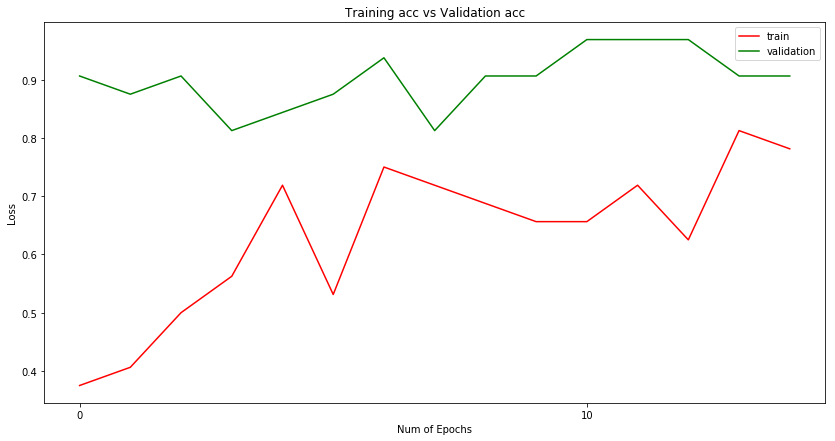

In [ ]:
plt.figure(figsize=(14, 7))
#plt.plot(result.history['loss'],'r')
#plt.plot(result.history['val_loss'],'g')
plt.plot(result.history['acc'],'r')
plt.plot(result.history['val_acc'],'g')

plt.xticks(np.arange(0, num_epochs+1, 10.0))
#plt.yticks(np.arange(0.5,1))
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training acc vs Validation acc")
plt.legend(['train','validation'])
plt.show()

In [ ]:
#Loops through ImageDataGenerator and grabs true labels and predictions
#and reports metrics with classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))

In [ ]:
model.load_weights('/content/drive/My Drive/Breast-Cancer-Wajeeha-Work/Detecting-Breast-Cancer-with-Comptuer-Vision-master/Detecting-Breast-Cancer-with-Comptuer-Vision-master/Weights/weights-improvement-11-0.97.hdf5')
predict_and_report(validation_generator, model)
predict_and_report(train_generator, model)